In [452]:
## Common Python modules
import math, sys
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

## EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Libraries for models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [453]:
## Importing the data
path = 'data/creditcardmarketing.xlsx'
df = pd.read_excel(path)
df.columns = [i.lower().replace(' ','_').replace('#', 'n') for i in df.columns]
df = df.drop('customer_number', axis=1)

In [544]:
## functions (this could then stored in another python file)

def get_outliers_index_categorical(df, threshold=0.02):

    def outlier_values_generator(value_counts_serie, threshold=threshold):
    ## yields a value from the counts if 
        serie = value_counts_serie
        for i in range(len(serie)):
            if serie.values[i] < serie.sum() * threshold:
                ## yield if the value_counts is lower than the threshold
                ## threshold * sum() == total_values for that percentage: 10% of 1000 => 100
                print(f'''{serie.values[i]} outliers found for the value ""{serie.index[i]}" in {column_name}''')
                
                yield value_counts_serie.index[i]
            
    
    for column_name in df:
        column = data[column_name] ## Easier to call later
        vc_serie = column.value_counts() ## Get the value counts dataframe

        arr = [i for i in outlier_values_generator(vc_serie)]
        result = (column[column.isin(arr)].index)
        ## Get the index when the value is in the array I got.
        ## is in is similar to serie[serie==value] => but uses an array for computation instead.
        yield result   

def get_outliers_index_iqr(column, threshold=1.5):
    
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = abs(q3-q1)
    
    condition1 = column > q3 + iqr * threshold
    condition2 = column > q1 - iqr * threshold
    
    result = column[condition1 & condition2].index
    return result

def get_pairs(n_rows, n_cols):
    '''Gives you pairs for ploting subploting with an iteration'''
    for i in range(n_rows):
        for j in range(n_cols):
            yield(i,j)
            ## This yielding may look strange 
            ## but is the only way I found to later
            ## pass the code to the axes.


def n_outliers(df, column_name):
    q1 = np.percentile(df[column_name], 25)
    q3 = np.percentile(df[column_name], 75)
    iqr = abs(q3 - q1)
    
    lower = df[column_name][df[column_name] < q1 - 1.5 * iqr]
    higher = df[column_name][df[column_name] > q3 + 1.5 * iqr]
    
    n_lower = len(lower)
    n_higher = len(higher)
    n_total = len(lower) + len(higher)
    
    
    array = np.array([n_lower, round(n_lower/len(df),3) , round(q1 - 1.5 * iqr,2), 
                      n_higher, round(n_higher/len(df),3),  round(q3 + 1.5 * iqr,3),
                      n_total, round(n_total/len(df),3) ,'none']).reshape(3,3)
    
    result = pd.DataFrame(data=array, index=['Lower Higher Total'.split(' ')], columns=['Counts', 'Percentage',
                                                                                        'Threshold'])
    return result


def print_target_per_discrete(data): 
    
    ## Variables used in all the columns
    total_percentage_no = data.iloc[:,-1].value_counts()['No'] / len(data)
    total_percentage_yes = data.iloc[:,-1].value_counts()['Yes'] / len(data)
    
    def get_value_tuples(data, column_name):
        unique_values = sorted(data[column_name].unique())
        column = data[column_name]
        

        for value in unique_values:
            v_counts = data[column == value].offer_accepted.value_counts()
            total = v_counts.sum()

            ## Get the percentages per value_count
            if len(v_counts) == 2: # Because you could have the case that there is no value in one of them.
                percentage_no = round(v_counts['No'] / total ,3)
                percentage_yes = round(v_counts['Yes'] / total, 3)
                
                
                variation_no = round(percentage_no - total_percentage_no, 3)
                variation_yes = round(percentage_yes - total_percentage_yes, 3)
                
                
                variation_percentage_no = round((variation_no / total_percentage_no),3) * 100
                variation_percentage_yes = round((variation_yes / total_percentage_yes),3) * 100
                               
                
                tup = (total, percentage_no, percentage_yes,
                       variation_percentage_no, variation_percentage_yes)
                
                yield tup  

    
    
    
    for column_name in data.columns[:-1]:
        df = pd.DataFrame([i for i in get_value_tuples(data, column_name)])
        print(df)
        df.columns = ['total_per_value', '
        get_value_tuples(data, column_name)
        print('\n')
        

In [545]:
## First thing I want is to get the 5 value tuple instead.
print_target_per_discrete(data.iloc[:,-3:])

      0      1      2    3     4
0  4241  0.980  0.020  3.8 -64.4
1  4148  0.897  0.103 -5.0  84.1
2  4194  0.955  0.045  1.2 -19.7


      0      1      2    3    4
0  4446  0.944  0.056 -0.0  0.0
1  8137  0.944  0.056 -0.0  0.0




## 1. EDA

### 1.1. Basic Bird's Eye View

In [455]:
df.shape

(18000, 16)

In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_accepted        18000 non-null  object 
 1   reward                18000 non-null  object 
 2   mailer_type           18000 non-null  object 
 3   income_level          18000 non-null  object 
 4   n_bank_accounts_open  18000 non-null  int64  
 5   overdraft_protection  18000 non-null  object 
 6   credit_rating         18000 non-null  object 
 7   n_credit_cards_held   18000 non-null  int64  
 8   n_homes_owned         18000 non-null  int64  
 9   household_size        18000 non-null  int64  
 10  own_your_home         18000 non-null  object 
 11  average_balance       17976 non-null  float64
 12  q1_balance            17976 non-null  float64
 13  q2_balance            17976 non-null  float64
 14  q3_balance            17976 non-null  float64
 15  q4_balance         

In [457]:
df.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
n_bank_accounts_open     0
overdraft_protection     0
credit_rating            0
n_credit_cards_held      0
n_homes_owned            0
household_size           0
own_your_home            0
average_balance         24
q1_balance              24
q2_balance              24
q3_balance              24
q4_balance              24
dtype: int64

In [458]:
data = df.offer_accepted[df.q1_balance.isna()]
data.value_counts()
## Just check before droping that th distribution is not that off.

No     22
Yes     2
Name: offer_accepted, dtype: int64

In [459]:
balance_nan_drop = df[df.q1_balance.isna()].index
df = df.drop(balance_nan_drop, errors='ignore')
##Just delete all the values were the balances are nan
df['q1_balance'].isna().sum()

0

In [460]:
df.describe()

,n_bank_accounts_open,n_credit_cards_held,n_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


### 1.2 Check for general outliers

In [461]:
continuous = df.select_dtypes(include='float')
discrete = df.select_dtypes(include='int')
target = df.offer_accepted
categorical = df.select_dtypes(include='object').drop('offer_accepted', axis=1)

In [462]:
print(len(continuous.columns) + len(discrete.columns) + len(categorical.columns) )

15


In [463]:
data = df.select_dtypes('float').drop('average_balance',axis=1)

q1_outliers = get_outliers_index_iqr(data.q1_balance, threshold=1.2) ## This can still 
q2_outliers = get_outliers_index_iqr(data.q2_balance, threshold=1.2)
q3_outliers = get_outliers_index_iqr(data.q3_balance, threshold=1.2)
q4_outliers = get_outliers_index_iqr(data.q4_balance, threshold=1.2)
outliers_index_continuous = np.unique(np.concatenate([q1_outliers,q2_outliers
                                            ,q3_outliers,q4_outliers], 0))

outliers_index_continuous

array([ 2296,  2655,  8777,  8887, 10475, 10576, 12633, 12635, 14003,
       15259, 15608])

In [464]:
data = df.select_dtypes('int')
indexes = [i for i in get_outliers_index_categorical(data, threshold=0.015)] # 1.5% of the data as outliers
outliers_index_discrete = (np.unique(np.concatenate(indexes))) # np.unique eliminates redundancy between indexes
print(f'\nLength of the array: {len(outliers_index_discrete)}')
outliers_index_discrete[:10] ## Showing only the first 10

185 outliers found for the value ""3" in n_homes_owned
1 outliers found for the value ""8" in household_size
1 outliers found for the value ""9" in household_size

Length of the array: 187


array([ 38,  58,  95, 101, 104, 481, 495, 527, 760, 824])

In [465]:
data = df.select_dtypes('object')
indexes = [i for i in get_outliers_index_categorical(data, threshold=0.015)] # 1.5% of the data as outliers
outliers_index_categorical = (np.unique(np.concatenate(indexes)))
print(f'\nLength of the array: {len(outliers_index_categorical)}')
outliers_index_categorical[:10] ## Showing only the first 10


Length of the array: 0


array([], dtype=int64)

### 1.3 Train test split

In [466]:
## Split the data
X = df.drop('offer_accepted', axis=1)
y = df['offer_accepted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=30)

In [467]:
y

0        No
1        No
2        No
3        No
4        No
         ..
17995    No
17996    No
17997    No
17998    No
17999    No
Name: offer_accepted, Length: 17976, dtype: object

In [252]:
## Get all the matrices for training data
data = X_train # Just to maintain consistency.
continuous_train = data.select_dtypes(include='float')
discrete_train = data.select_dtypes(include='int')
categorical_train = data.select_dtypes(include='object') # droping the target is not needed anymore.

## Get all the matrices for test data
data = X_test
continuous_test = data.select_dtypes(include='float')
discrete_test = data.select_dtypes(include='int')
categorical_test = data.select_dtypes(include='object') 

In [253]:
print('train matrices shapes')
for matrix in [continuous_train,discrete_train,categorical_train]:
    print(matrix.shape)

print('\ntest matrices shapes')
for matrix in [continuous_test,discrete_test,categorical_test]:
    print(matrix.shape)

train matrices shapes
(12583, 5)
(12583, 4)
(12583, 6)

test matrices shapes
(5393, 5)
(5393, 4)
(5393, 6)


### 1.4 Check the Value Counts of the target.

In [217]:
data = y_train
data.value_counts()

No     11880
Yes      703
Name: offer_accepted, dtype: int64

In [218]:
v_counts = data.value_counts()
v_counts['No'] / v_counts['Yes'] 

16.89900426742532

In [219]:
## What if Just everything is No.
v_counts['No'] / len(target)

0.6608811748998665

It is clear that the target is not well balance. We can see that there is 16.9 times more rejections than accepted offers. This means that if you preddict everything as a 'No' you will actually have more than **94% correct values**. 

### 4) Cheking Continuous Data 

In [267]:
data = continuous_train

In [269]:
## This is how it is calculated. First getting the mean of all the values and 
## then apply a describe function.
data.iloc[:,1:].mean(axis=1).describe()

count    12583.000000
mean       938.661269
std        351.859466
min         48.250000
25%        787.750000
50%       1007.750000
75%       1151.375000
max       3366.250000
dtype: float64

The first thing we can see that there is a column that is **dependent** on the other 4. This means we can just drop the column. 

In [270]:
average_balance = data['average_balance']
data = data.drop('average_balance',axis=1)

In [271]:
data.describe()

,q1_balance,q2_balance,q3_balance,q4_balance
count,12583.000000,12583.000000,12583.000000,12583.000000
mean,912.464436,997.503060,1037.259636,807.417945
std,619.506209,458.742749,553.314917,560.870314
min,0.000000,1.000000,0.000000,0.000000
25%,392.000000,661.000000,629.000000,356.000000
50%,778.000000,1032.000000,942.000000,699.000000
75%,1526.000000,1339.000000,1457.000000,1210.500000
max,2509.000000,3421.000000,3823.000000,4215.000000


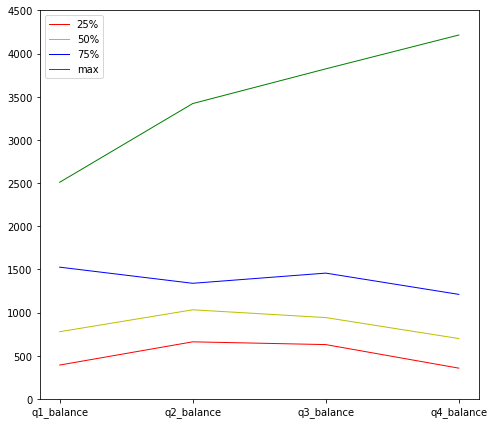

In [272]:
rows = ['25%', '50%', '75%', 'max']
colors = ['r', 'y','b','g']
l_rows = len(rows)

fig = plt.figure(figsize=(7,6))

for i in range(len(rows)):
    column_name = rows[i]
    x = data.describe().loc[column_name].index ## Row name is the 25%, 50%...
    y = data.describe().loc[column_name].values
    plt.plot(x, y , color=colors[i],linewidth=1, label=rows[i])
    
plt.legend()
plt.ylim(0, 4500)
    
plt.tight_layout()
plt.show()

This is not super precise, but it gives an idea of how behaviour of the different groups from the riches to the poorest. What can be observed is that both **25% and 50%** people start low, gets a better balance throughout the year and then it returns back to low. The **75%** starts high and then slowly descends. And the **100%** keeps going up. This is of course a single value consideration; and the max is probably an outlier. But since the percentiles are calculated by columns and not rows; it could already be giving some insight on the data.

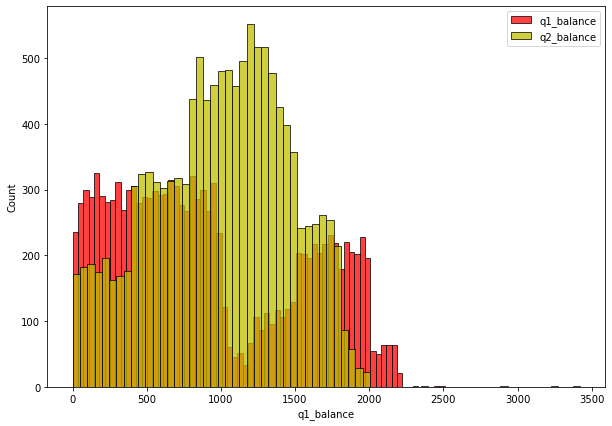

In [273]:
colors = ['r', 'y']
fig, axs = plt.subplots(1,1, figsize=(10,7))
for i in range(2):
    sns.histplot(data=data, x=data.columns[i],
                 bins=70, ax=axs, color=colors[i], label=data.columns[i])

plt.legend()
plt.show()

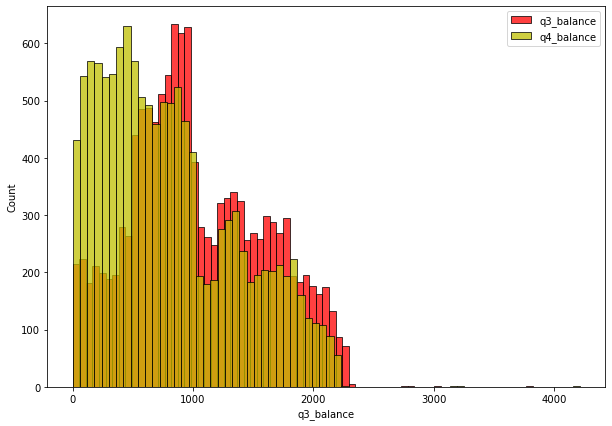

In [274]:
colors = ['r', 'y']
fig, axs = plt.subplots(1,1, figsize=(10,7))
for i in range(2):
    sns.histplot(data=data, x=data.columns[i+2],
                 bins=70, ax=axs, color=colors[i], label=data.columns[i+2])

plt.legend()
plt.show()

This shows a lot of stuff:
1) That there are a lot of outliers, specially in the highest range of the values
<br>2) It looks as if there was some kind of pumping (like a heart)
<br>3) The amount of people with a balance lower to 1000 is highes at the q4 (guess at the end of the year).

Now it is shown the boxplots between each q and the target.

In [275]:
data = pd.concat([data,y_train],axis=1)

In [277]:
data

,q1_balance,q2_balance,q3_balance,q4_balance,offer_accepted
3257,875.0,817.0,913.0,580.0,No
14091,633.0,714.0,839.0,580.0,No
17881,225.0,214.0,7.0,67.0,No
17701,198.0,51.0,349.0,105.0,No
3091,1367.0,842.0,775.0,996.0,No
...,...,...,...,...,...
501,178.0,472.0,5.0,381.0,No
12091,630.0,757.0,854.0,849.0,No
15298,911.0,812.0,618.0,888.0,No
4521,1639.0,1805.0,1608.0,1518.0,No


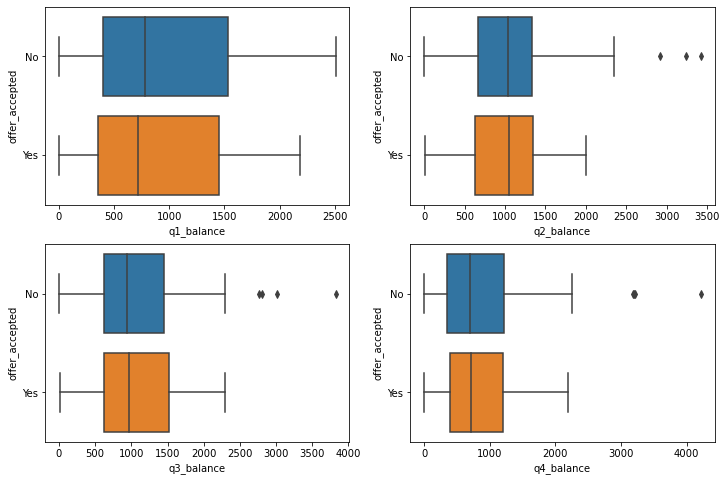

In [279]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
pairs = [i for i in get_pairs(2,2)] # This is needed to make the iteration below work.

for i in range(4):
    axs[pairs[i]].x_lim = (0,4500)
    sns.boxplot(data=data,x=data.columns[i], y='offer_accepted', ax=axs[pairs[i]]) 
plt.show()

As **unexpected** as it may sound, it doesn't seem to be much correlation between the balance someone has and if the accept or not their offer.

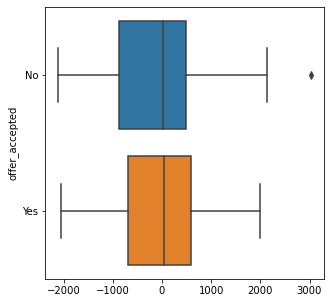

In [280]:
variance_q1_q4 = data['q4_balance'] - data['q1_balance'] ## Because probably what they are watching 
                                                         ## is the way they spend the money.
    
fig = plt.figure(figsize=(5,5))
sns.boxplot(data=data,x=variance_q1_q4, y='offer_accepted') 
plt.show()

## Better, but there is doesn't seem to be significant correlation.

Finally it would be shown what is the relationship between **offer_accepted** and the **outliers**. For this it would be used the average balance.

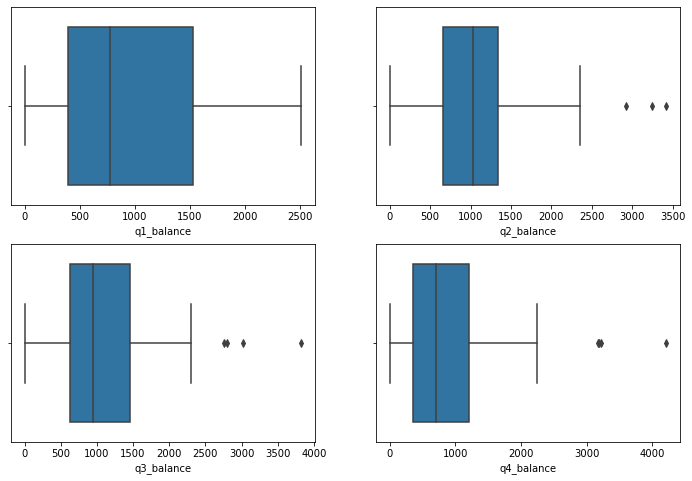

In [288]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
pairs = [i for i in get_pairs(2,2)] # This is needed to make the iteration below work.

for i in range(4):
    axs[pairs[i]].x_lim = (0,4500)
    sns.boxplot(data=data,x=data.columns[i],  ax=axs[pairs[i]]) 
plt.show()

In [287]:
q1_outliers = get_outliers_index_iqr(data.q1_balance, threshold=1.5)
q2_outliers = get_outliers_index_iqr(data.q2_balance, threshold=1.5)
q3_outliers = get_outliers_index_iqr(data.q3_balance, threshold=1.5)
q4_outliers = get_outliers_index_iqr(data.q4_balance, threshold=1.5)
index = np.unique(np.concatenate([q1_outliers,q2_outliers
                                  ,q3_outliers,q4_outliers], 0))
print(f'size index: {len(index)}\n')

df.offer_accepted[index].value_counts()

size index: 6



No    6
Name: offer_accepted, dtype: int64

All outlers are **being regected**. This may have many reasons that are out of the scope of this analysis.

<function matplotlib.pyplot.show(close=None, block=None)>

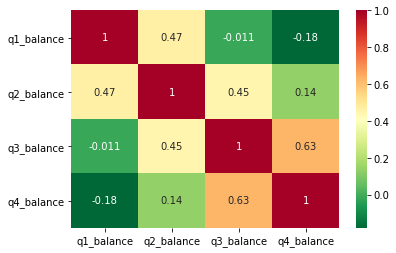

In [289]:
corr = data.corr(method='spearman')
sns.heatmap(corr, cmap='RdYlGn_r',  annot=True)
plt.show

It can be seen that the correlation is not that high. Probably the only thing that is interesting is the negative correlation between balance 1 and the balances 3 and balance 4.

<AxesSubplot:xlabel='q1_balance', ylabel='q4_balance'>

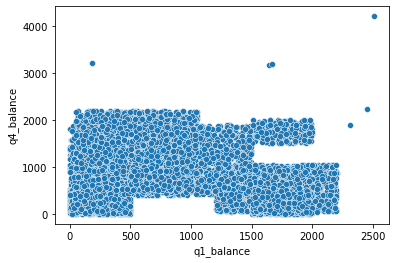

In [145]:
sns.scatterplot(data=data, x='q1_balance',y='q4_balance')

<AxesSubplot:xlabel='q1_balance', ylabel='q3_balance'>

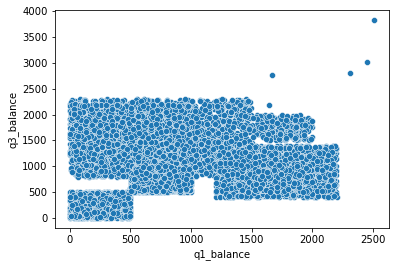

In [146]:
sns.scatterplot(data=data, x='q1_balance',y='q3_balance')

<AxesSubplot:xlabel='q3_balance', ylabel='q4_balance'>

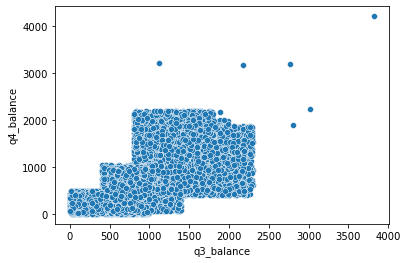

In [147]:
sns.scatterplot(data=data, x='q3_balance',y='q4_balance')

<AxesSubplot:xlabel='q2_balance', ylabel='q3_balance'>

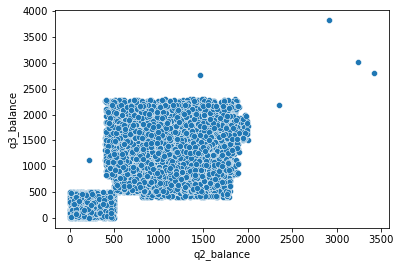

In [149]:
sns.scatterplot(data=data, x='q2_balance',y='q3_balance')

I deffinetely wasn't expecting this sort of **behaviour**. Not even sure what to do with this.

In [290]:
data.q1_balance.sample(10)

16251      65.0
13813     161.0
4525     1464.0
8092       60.0
7132      943.0
17700     224.0
11610      71.0
5259      326.0
10855    1722.0
9089      755.0
Name: q1_balance, dtype: float64

### 5) Checking Discrete Data

In [293]:
data = discrete_train

In [305]:
for column_name in data:

    df = data[column_name].value_counts()
    index = df.index.sort_values()
    print(column_name)
    print(df[index])
    print('\n')

n_bank_accounts_open
1    9586
2    2797
3     200
Name: n_bank_accounts_open, dtype: int64


n_credit_cards_held
1    4303
2    5578
3    2331
4     371
Name: n_credit_cards_held, dtype: int64


n_homes_owned
1    10146
2     2303
3      134
Name: n_homes_owned, dtype: int64


household_size
1     392
2    1908
3    3971
4    3935
5    2006
6     370
8       1
Name: household_size, dtype: int64




Most columns in **discrete** have less than **5 value**. The only one that doesn't follow this rule is **household_size** which **has 8**. Nevertheless, it can be seen that value 8 have only 1 entry. 

It is clear what the **n_columns** are. But what is the meaning of **household_size** is more **ambiguous** .

In [308]:
y_train

3257     No
14091    No
17881    No
17701    No
3091     No
         ..
501      No
12091    No
15298    No
4521     No
5932     No
Name: offer_accepted, Length: 12583, dtype: object

In [478]:
data = pd.concat([discrete_train, y_train], axis=1)
data = data.astype(int, errors='ignore')

In [444]:
total = len(data)
yes_percentage = round(data.offer_accepted.value_counts()['Yes'] / total,3)
no_percentage =  round(data.offer_accepted.value_counts()['No'] / total,3)

print(f'total_distribution: ({no_percentage},{yes_percentage})\n')
print_target_per_discrete(data) 

total_distribution: (0.944,0.056)

n_bank_accounts_open
1: (0.943, 0.057)
2: (0.946, 0.054)
3: (0.96, 0.04)


n_credit_cards_held
1: (0.942, 0.058)
2: (0.946, 0.054)
3: (0.943, 0.057)
4: (0.943, 0.057)


n_homes_owned
1: (0.945, 0.055)
2: (0.941, 0.059)
3: (0.955, 0.045)


household_size
1: (0.921, 0.079)
2: (0.949, 0.051)
3: (0.94, 0.06)
4: (0.945, 0.055)
5: (0.95, 0.05)
6: (0.954, 0.046)
8: (0.954, 0.046)




### 6) Cheking Categorical Data

In [481]:
data = pd.concat([categorical_train,y_train],axis=1)

In [477]:
for column_name in data.columns:
    print(column_name)
    print(data[column_name].value_counts())
    print('\n')

reward
Air Miles    4237
Points       4177
Cash Back    4169
Name: reward, dtype: int64


mailer_type
Postcard    6349
Letter      6234
Name: mailer_type, dtype: int64


income_level
Medium    6305
High      3174
Low       3104
Name: income_level, dtype: int64


overdraft_protection
No     10668
Yes     1915
Name: overdraft_protection, dtype: int64


credit_rating
High      4241
Medium    4194
Low       4148
Name: credit_rating, dtype: int64


own_your_home
Yes    8137
No     4446
Name: own_your_home, dtype: int64


offer_accepted
No     11880
Yes      703
Name: offer_accepted, dtype: int64




We can see here three **types of distribution**: 
1) There are columns where the distribution is **balanced** (**reward, mailer_type, credit_rating**)
<br>2) Columns where there is a **mild imbalance** ( **income level, own_your_home**)
<br>3) Columns where there is **a lot of imbalance** (**overdraft_protection**)

In [482]:
total = len(data)
yes_percentage = round(data.offer_accepted.value_counts()['Yes'] / total,3)
no_percentage =  round(data.offer_accepted.value_counts()['No'] / total,3)

print(f'total_distribution: ({no_percentage},{yes_percentage})\n')
print_target_per_discrete(data) 

total_distribution: (0.944,0.056)

reward
Air Miles: (0.926, 0.074)
Cash Back: (0.965, 0.035)
Points: (0.941, 0.059)


mailer_type
Letter: (0.968, 0.032)
Postcard: (0.921, 0.079)


income_level
High: (0.963, 0.037)
Low: (0.917, 0.083)
Medium: (0.948, 0.052)


overdraft_protection
No: (0.944, 0.056)
Yes: (0.946, 0.054)


credit_rating
High: (0.98, 0.02)
Low: (0.897, 0.103)
Medium: (0.955, 0.045)


own_your_home
No: (0.944, 0.056)
Yes: (0.944, 0.056)


